In [105]:
import math

import matplotlib.pyplot as plt
import librosa.feature
import librosa.display
import numpy as np
from IPython.display import Audio, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import ruptures as rpt  # our package
import IPython.display as ipd
import pandas as pd


In [106]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

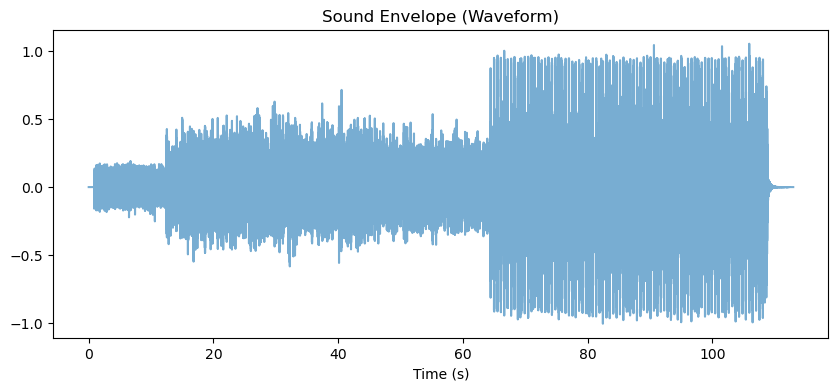

In [107]:
duration = 450
signal, sr = librosa.load(
    r"DO NOT TOUCH/Audio Files/Emmanuel/01. Vitalic.flac",
    sr = None,                                                                      # <-- CAN BE CHANGED :))
    duration=duration
)
print(f"Loaded signal with shape: {signal.shape}, Sampling rate: {sr}")

# listen to the music
display(Audio(data=signal, rate=sr))

# Plot waveform
time = np.arange(len(signal)) / sr
plt.figure(figsize=(10, 4))
plt.plot(time, signal, alpha=0.6)
plt.xlabel("Time (s)")
plt.title("Sound Envelope (Waveform)")
plt.show()

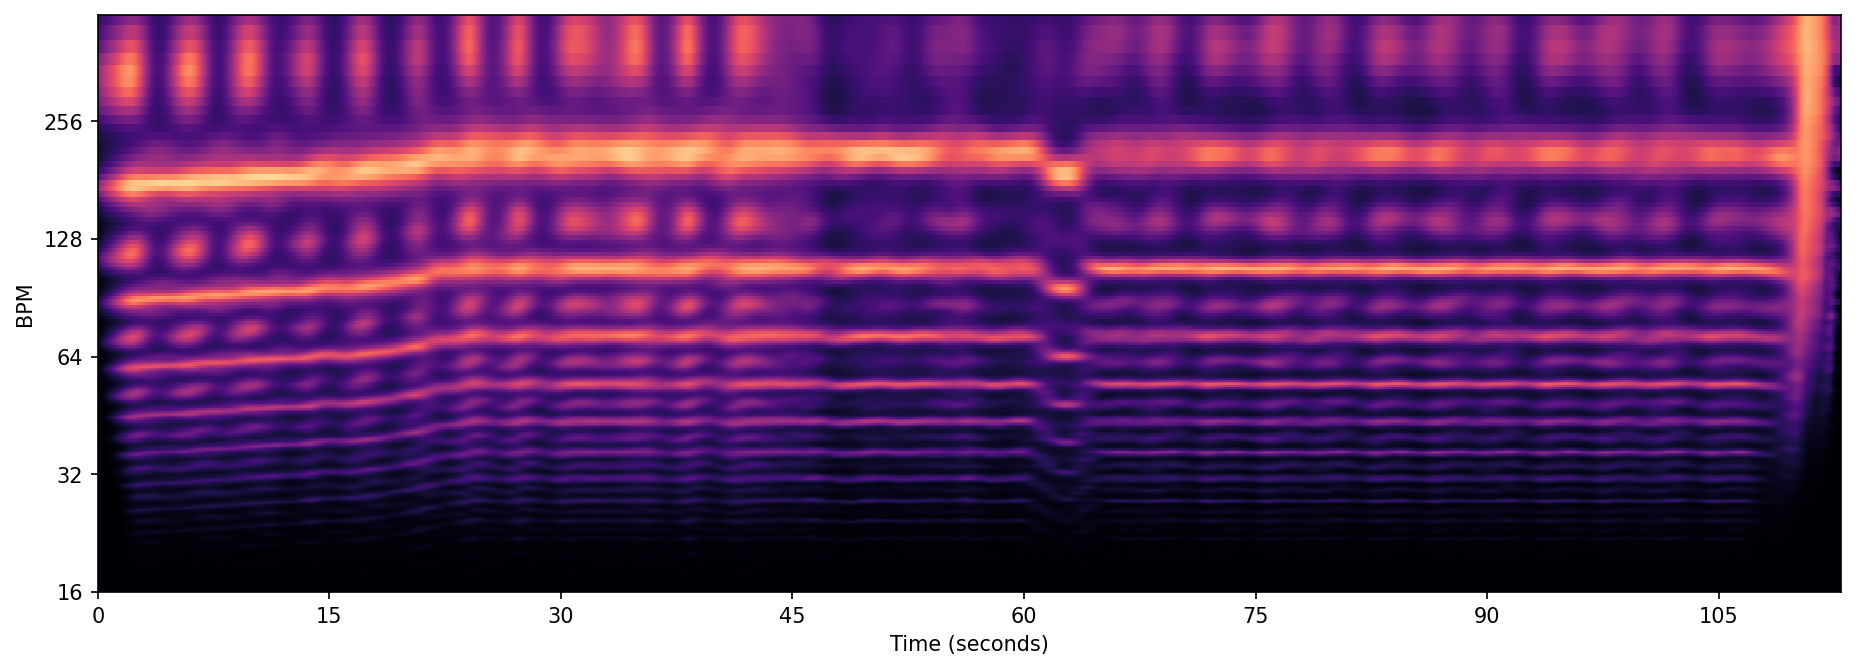

In [108]:
# Compute the onset strength
hop_length_tempo = 256                                                                       # <-- CAN BE CHANGED :))
oenv = librosa.onset.onset_strength(
    y=signal, sr=sr, hop_length=hop_length_tempo
)
# Compute the tempogram
tempogram = librosa.feature.tempogram(
    onset_envelope=oenv,
    sr=sr,
    hop_length=hop_length_tempo,
)
# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sr,
    x_axis="s",
    y_axis="tempo",
)

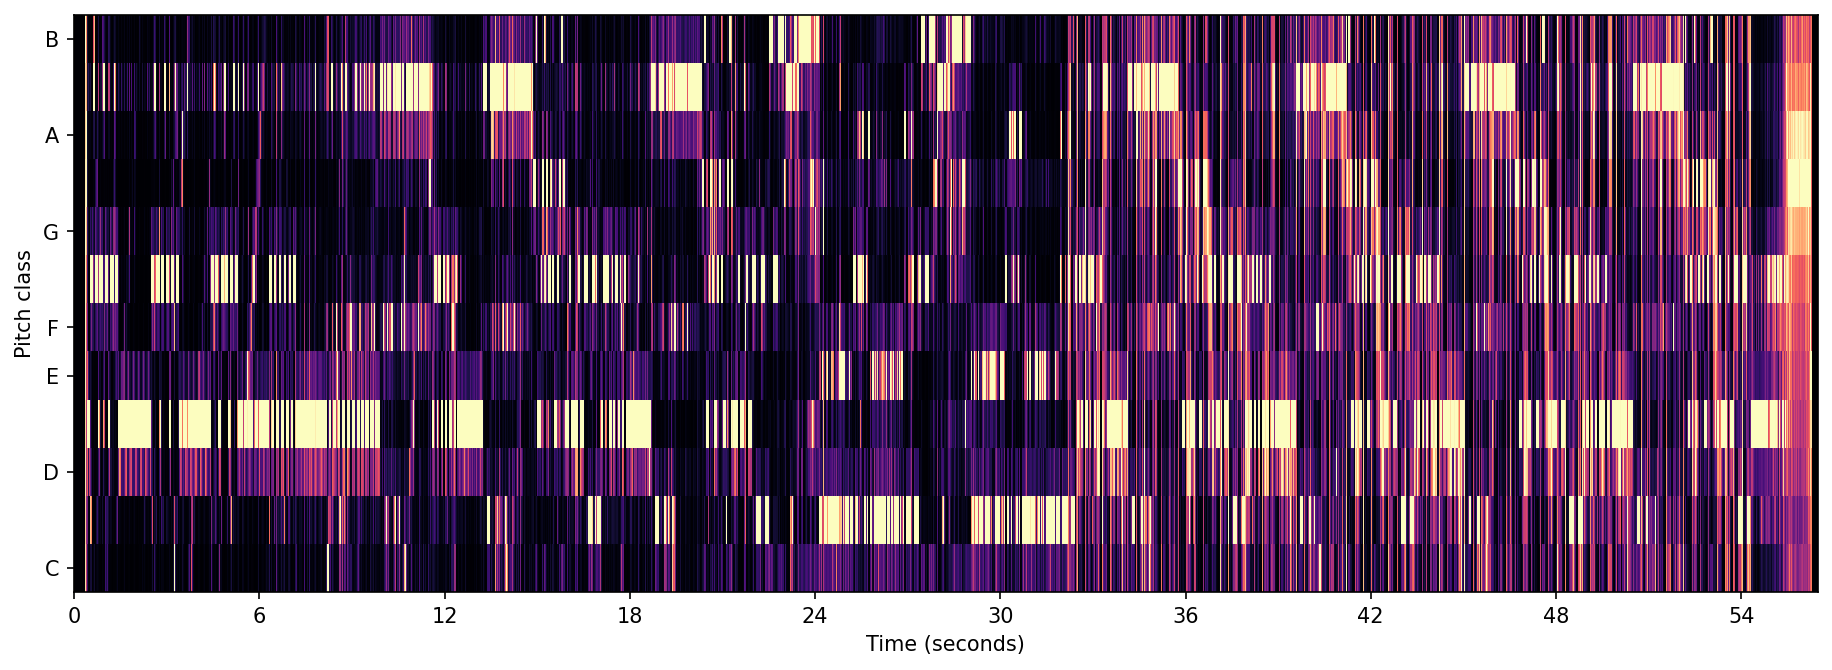

In [119]:
# Compute the Chromagram
# Extract chroma features (try chroma_cqt or chroma_cens)
chroma = librosa.feature.chroma_stft(y=signal, sr=sr, n_chroma=12)                       # <-- CAN BE CHANGED :))  - Go into the packages.. im sorry..

# Normalize chroma features
chroma = librosa.util.normalize(chroma, axis=1)                       # <-- see if this does anything

# Transpose to shape (time_steps, features)
chroma_T = chroma.T  # shape: (frames, 12)

# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    chroma,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sr,
    x_axis="s",
    y_axis="chroma",
)

In [109]:
# Choose detection method TEMPOGRAMS
algoTEM = rpt.KernelCPD(kernel="linear").fit(tempogram.T)                        # <-- CAN BE CHANGED :))

# Set the desired number of change points manually
n_bkps = 12                                                                      # <-- CAN BE CHANGED :))
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)

# Now bkps contains the detected change points
print(f"Detected change points: {bkpsTEM}")

Detected change points: [126, 569, 949, 1409, 1559, 1737, 1996, 3932, 5264, 5520, 9430, 9639, 9729]


In [110]:
# Choose detection method CHROMAGRAMS
# Changepoint detection with KernelCPD
algoCH = rpt.KernelCPD(kernel="linear").fit(chroma_T)                            # <-- CAN BE CHANGED :))

# Predict change points
bkpsCH = algoCH.predict(n_bkps=n_bkps)

print("Detected change points:", bkpsCH)

Detected change points: [854, 1000, 1141, 1282, 1611, 1752, 2080, 2363, 2503, 2773, 4771, 4848, 4865]


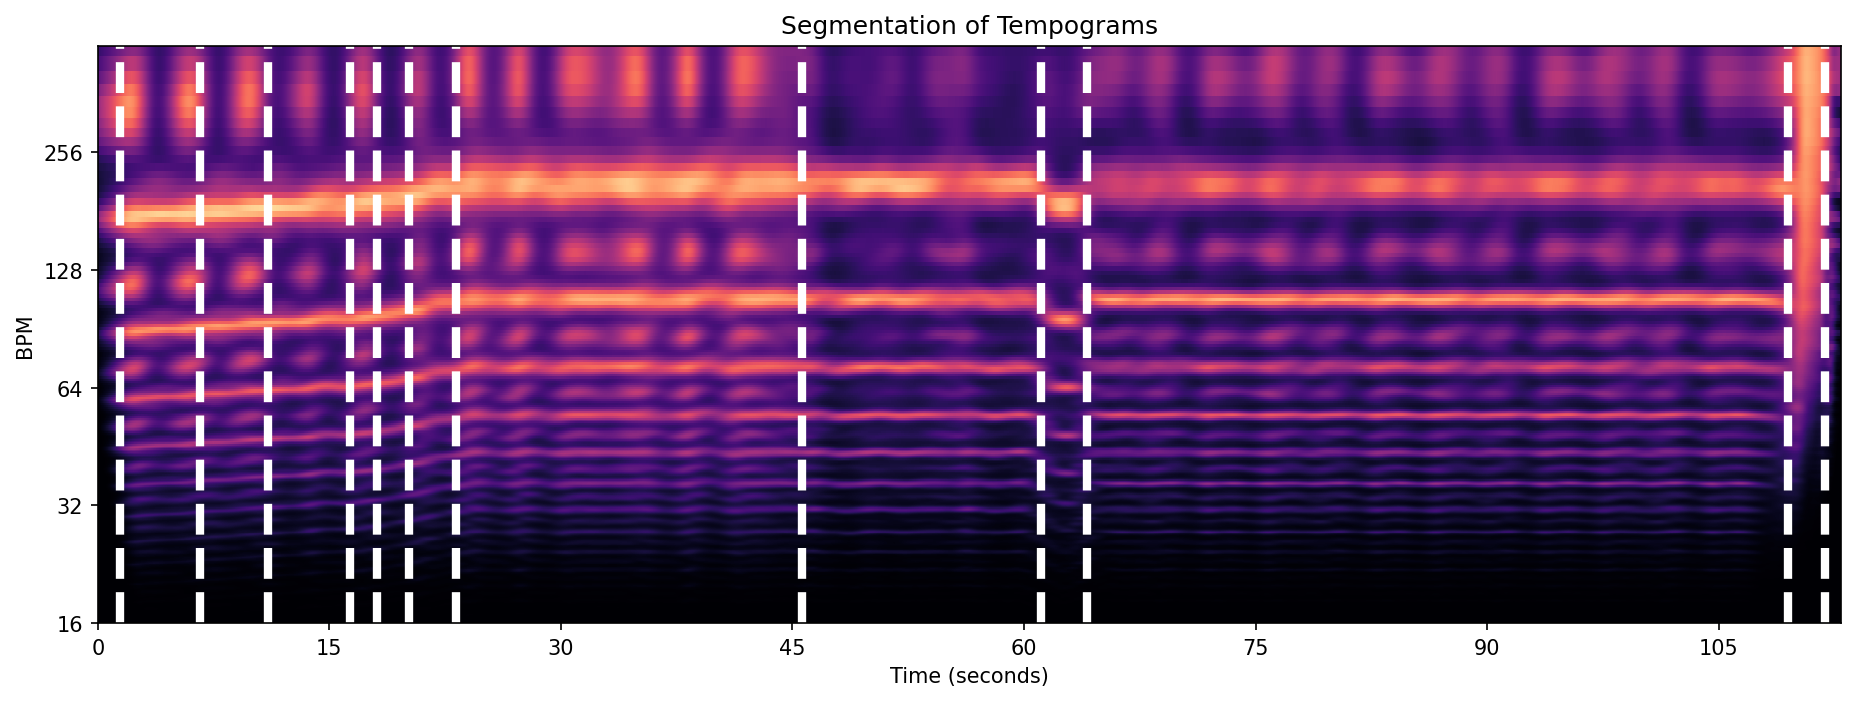

In [111]:
# Segmentation TEMPO
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_times = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=hop_length_tempo)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    label= "Segmentation of Tempograms",
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)

# Add title
ax.set_title("Segmentation of Tempograms")

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

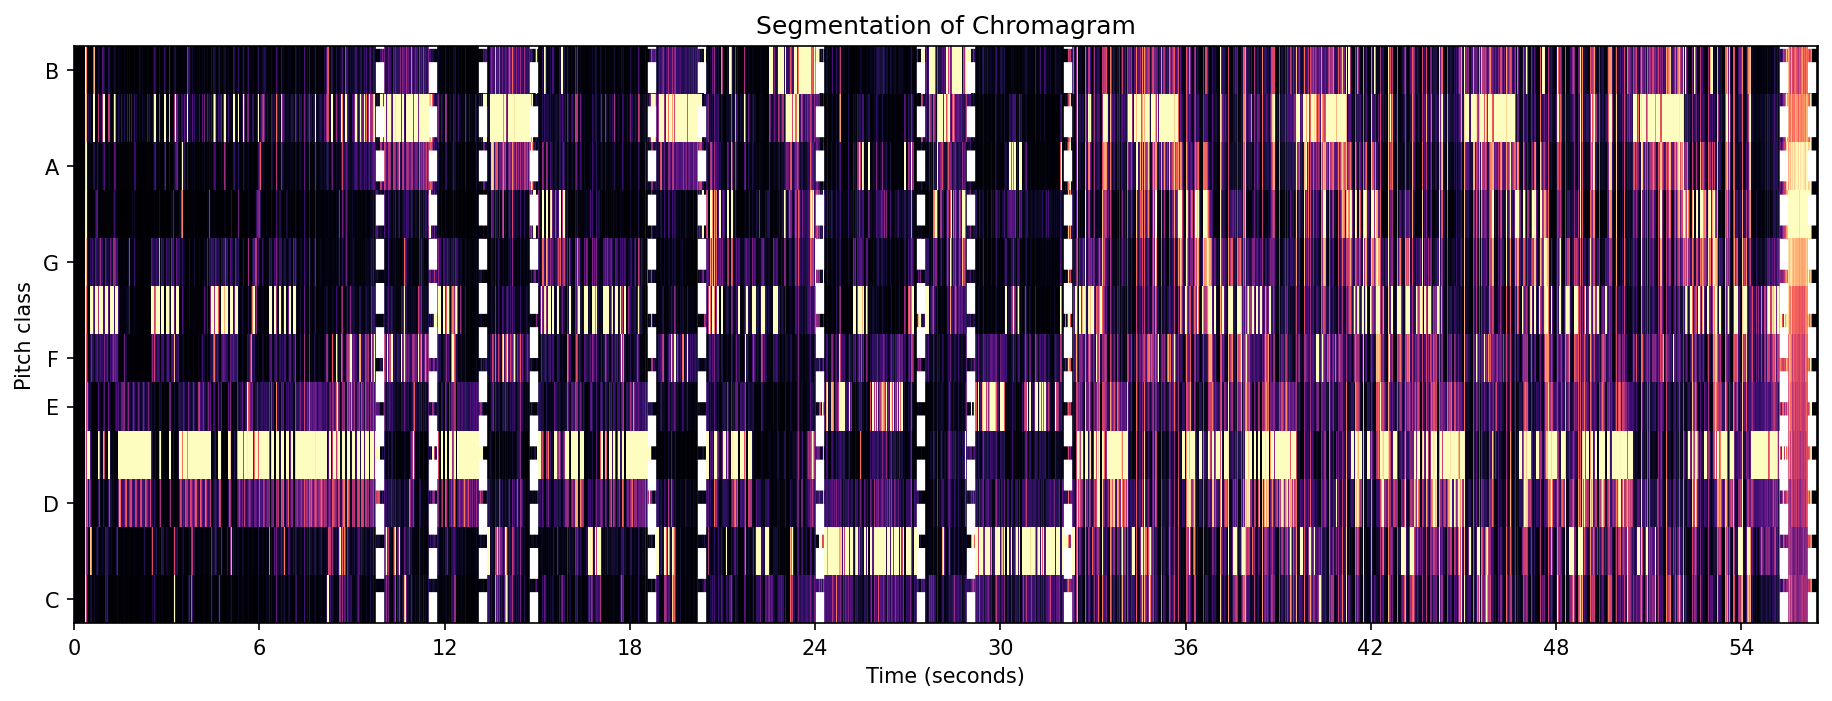

In [116]:
# Segmentation CHROMAGRAM
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkps_times = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_tempo)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    chroma,
    ax=ax,
    x_axis="s",
    y_axis="chroma",
    hop_length=hop_length_tempo,
    sr=sr,
)

# Add title
ax.set_title("Segmentation of Chromagram")

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)

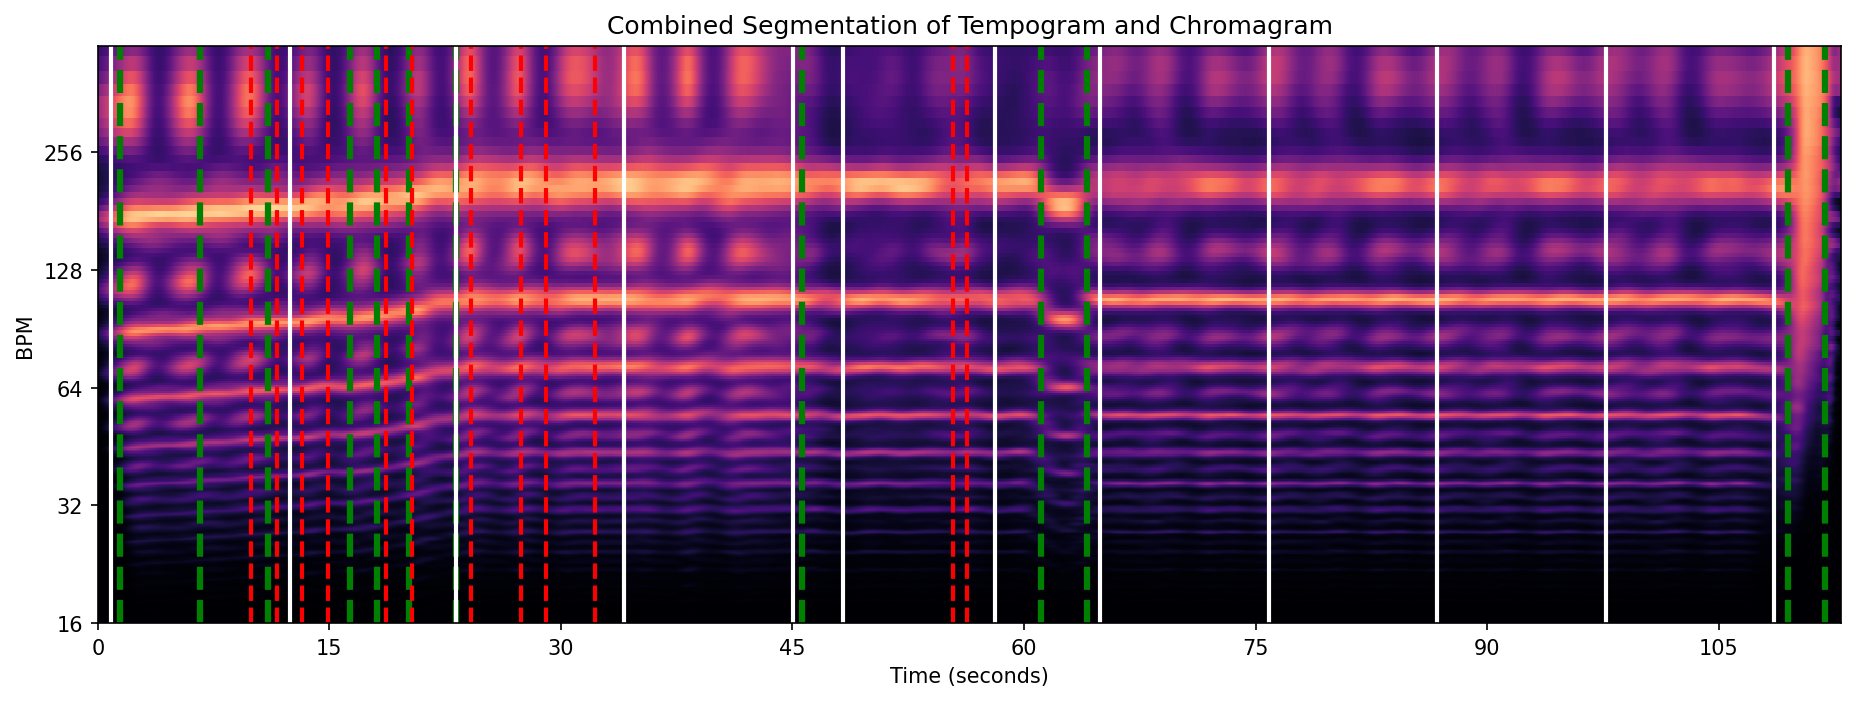

In [118]:
# TEMPO
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_times_TEM = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=hop_length_tempo)

# CHROMAGRAM
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkps_times_CH = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_tempo)

# Load GT
GT = "DO NOT TOUCH/GroundTruthData/GroundTruthRight/parsed_data_1.csv"
gt_data = pd.read_csv(GT)

# only timestamps
gt_times = gt_data["TIMESTAMP"].values

# display the figure
fig, ax = fig_ax()

# Display the tempogram as the background
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sr,
)

# Title
ax.set_title("Combined Segmentation of Tempogram and Chromagram")

# TEMPO segmentation points -  green dashed lines
for b in bkps_times_TEM[:-1]:
    ax.axvline(b, ls="--", color="green", lw=3, label="Tempo Segmentation" if b == bkps_times_TEM[0] else None)

# CHROMA segmentation points - red dashed lines
for b in bkps_times_CH[:-1]:
    ax.axvline(b, ls="--", color="red", lw=2, label="Chromagram Segmentation" if b == bkps_times_CH[0] else None)

# Ground Truth points - white solid lines
for b in gt_times:
    ax.axvline(b, ls="-", color="white", lw=2, label="Ground Truth" if b == gt_times[0] else None)

plt.show()


In [114]:
# === Your scoring function ===
def gaussian_score_flat_top(time_diff, sigma=0.9, flat_top=0.25):
    abs_diff = abs(time_diff)
    if abs_diff <= flat_top:
        return 100.0
    elif abs_diff >= 3:
        return 0.0
    else:
        adjusted_diff = abs_diff - flat_top
        return 100.0 * math.exp(- (adjusted_diff ** 2) / (2 * sigma ** 2))

# === Load ground truth from CSV ===
ground_truth_path = r"DO NOT TOUCH/GroundTruthData/GroundTruthRight/parsed_data_1.csv"
gt_times = pd.read_csv(ground_truth_path)['TIMESTAMP'].values  # Extract only 'TIMESTAMP' column

# === TEMPO Segmentation ===
bkpsTEM = algoTEM.predict(n_bkps=n_bkps)
bkps_times_TEM = librosa.frames_to_time(bkpsTEM, sr=sr, hop_length=hop_length_tempo)

# === CHROMAGRAM Segmentation ===
bkpsCH = algoCH.predict(n_bkps=n_bkps)
bkps_times_CH = librosa.frames_to_time(bkpsCH, sr=sr, hop_length=hop_length_tempo)

# === Scoring function ===
def evaluate_segmentation(predicted_times, gt_times, label=""):
    scores = []
    matched_preds = []

    for gt in gt_times:
        if len(predicted_times) == 0:
            scores.append(0.0)
            matched_preds.append(None)
            continue
        closest_pred = min(predicted_times, key=lambda p: abs(p - gt))
        matched_preds.append(closest_pred)
        time_diff = closest_pred - gt
        score = gaussian_score_flat_top(time_diff)
        scores.append(score)

    # === Print results ===
    print(f"\n--- Evaluation Results for {label} ---")
    for i, (gt, pred, score) in enumerate(zip(gt_times, matched_preds, scores), 1):
        if pred is not None:
            print(f"{i:02}: GT={gt:.2f}s | Closest Pred={pred:.2f}s | Diff={pred - gt:+.2f}s | Score={score:.2f}")
        else:
            print(f"{i:02}: GT={gt:.2f}s | Closest Pred=None | Diff=None | Score=0.00")

    avg_score = np.mean(scores)
    print(f"\nAverage Score for {label}: {avg_score:.2f}\n")
    return scores, avg_score

# === Evaluate TEMPO ===
tempo_scores, avg_tempo_score = evaluate_segmentation(bkps_times_TEM, gt_times, label="Tempo")

# === Evaluate CHROMAGRAM ===
chroma_scores, avg_chroma_score = evaluate_segmentation(bkps_times_CH, gt_times, label="Chromagram")



--- Evaluation Results for Tempo ---
01: GT=0.88s | Closest Pred=1.46s | Diff=+0.59s | Score=93.27
02: GT=12.47s | Closest Pred=11.02s | Diff=-1.45s | Score=41.23
03: GT=23.21s | Closest Pred=23.17s | Diff=-0.04s | Score=100.00
04: GT=34.09s | Closest Pred=23.17s | Diff=-10.92s | Score=0.00
05: GT=45.02s | Closest Pred=45.65s | Diff=+0.63s | Score=91.41
06: GT=48.28s | Closest Pred=45.65s | Diff=-2.63s | Score=2.99
07: GT=58.10s | Closest Pred=61.11s | Diff=+3.02s | Score=0.00
08: GT=64.93s | Closest Pred=64.09s | Diff=-0.85s | Score=80.31
09: GT=75.87s | Closest Pred=64.09s | Diff=-11.79s | Score=0.00
10: GT=86.75s | Closest Pred=64.09s | Diff=-22.66s | Score=0.00
11: GT=97.67s | Closest Pred=109.48s | Diff=+11.81s | Score=0.00
12: GT=108.59s | Closest Pred=109.48s | Diff=+0.89s | Score=77.84

Average Score for Tempo: 40.59


--- Evaluation Results for Chromagram ---
01: GT=0.88s | Closest Pred=9.91s | Diff=+9.04s | Score=0.00
02: GT=12.47s | Closest Pred=13.25s | Diff=+0.78s | Score